# Analyse artificially introduced noise
Files needed:
* dataframes files (obtained by running *count_forgotten_events.py* on the corresponding experiments):
  * forgetting-random-product.csv: cleaned dataset with "easy-noise" introduced 
  * forgetting-top3-product.csv: cleaned dataset with "hard-noise" introduced
* noisy reaction files for the TWO kind of noise:
  * precursors.txt
  * product.txt
For more details on the noising startegies: https://chemrxiv.org/articles/preprint/Unassisted_Noise-Reduction_of_Chemical_Reactions_Data_Sets/12395120/1

Variables to set: **filespath**, **noise_path_random_product**, **noise_path_top3_product**

Outputs:
* "figures/": the plots

In [1]:
import pandas as pd
import math

filespath = "path/to/dataframe/files"  # likely "files"
savepath = "figures"

In [ ]:
df_forgetting = pd.read_csv(filespath + "/forgetting.csv")
df_forgetting_random_product = pd.read_csv(filespath + "/forgetting-random-product.csv")
df_forgetting_top3_product = pd.read_csv(filespath + "/forgetting-top3-product.csv")

### Sort the dataframes

In [ ]:
df_forgetting = df_forgetting.sort_values(by='forgotten_events_with_inf', ascending=False).reset_index(drop=True)
df_forgetting_random_product = df_forgetting_random_product.sort_values(by='forgotten_events_with_inf', ascending=False).reset_index(drop=True)
df_forgetting_top3_product = df_forgetting_top3_product.sort_values(by='forgotten_events_with_inf', ascending=False).reset_index(drop=True)

### Load noisy examples

In [8]:
# random product
noise_path_random_product = "path/to/random/product/noise/files"

with open(noise_path_random_product + "/precursors.txt",'r') as f:
    prec_random = [line.strip() for line in f.readlines()]
with open(noise_path_random_product + "/product.txt",'r') as f:
    prod_random = [line.strip() for line in f.readlines()]

rxns_random = [prec_random[i] + ' >> ' + prod_random[i] for i in range(len(prec_random))]

In [ ]:
df_random_product = pd.DataFrame(rxns_random)
df_random_product.columns = ['noisy_rxns']

In [ ]:
# random product
noise_path_top3_product = "path/to/top3/product/noise/files"

with open(noise_path_top3_product + "/precursors.txt",'r') as f:
    prec_top3 = [line.strip() for line in f.readlines()]
with open(noise_path_top3_product + "/product.txt",'r') as f:
    prod_top3 = [line.strip() for line in f.readlines()]

rxns_top3 = [prec_top3[i] + ' >> ' + prod_top3[i] for i in range(len(prec_top3))]

In [ ]:
df_top3_product = pd.DataFrame(rxns_top3)
df_top3_product.columns = ['noisy_rxns']

### Check how many noisy examples are found within the most forgotten events

In [ ]:
def percentage_of_noise_found(df, noise_df, condition):
    
    precursors = list(df.loc[condition(df['forgotten_events_with_inf'])].tok_source.values)
    product = list(df.loc[df['forgotten_events_with_inf']>=5].tok_target.values)
    rxns = [precursors[i] + ' >> ' + product[i] for i in range(len(product))]

    df_filter = noise_df.isin(rxns)
    noise_df['filter'] = df_filter
    
    return len(noise_df.loc[noise_df['filter']==True])/len(noise_df)*100

In [ ]:
labels = ['top-3\nproduct','random\nproduct']

perc_noise_in_never_learnt_events = [
    percentage_of_noise_found(df_forgetting_top3_product, df_top3_product, lambda x: x == math.inf),
    percentage_of_noise_found(df_forgetting_random_product, df_random_product, lambda x: x == math.inf)
] 
perc_noise_down_to_5_forg_events = [
    percentage_of_noise_found(df_forgetting_top3_product, df_top3_product, lambda x: x >= 5),
    percentage_of_noise_found(df_forgetting_random_product, df_random_product, lambda x: x >= 5)
] 
perc_noise_down_to_1_forg_events = [
    percentage_of_noise_found(df_forgetting_top3_product, df_top3_product, lambda x: x >= 1),
    percentage_of_noise_found(df_forgetting_random_product, df_random_product, lambda x: x >= 1)
] 

### Plots for the noisy examples

In [41]:
noise_perc = [
    len(df_top3_product)/len(df_forgetting_top3_product)*100,
    len(df_random_product)/len(df_forgetting_random_product)*100 ]

[6.907147426431838, 6.907147426431838]

In [42]:
perc_never_learnt_events = [
    len(df_forgetting_top3_product.loc[df_forgetting_top3_product['forgotten_events_with_inf']==math.inf])/len(df_forgetting_top3_product)*100,
    len(df_forgetting_random_product.loc[df_forgetting_random_product['forgotten_events_with_inf']==math.inf])/len(df_forgetting_random_product)*100
]

[5.9178553650832075, 9.67382581572244]

In [45]:
def autolabel(rects, ax, vert_off = (3,0), font = 8):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{0:.3f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext = vert_off,  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='center').set_fontsize(font)

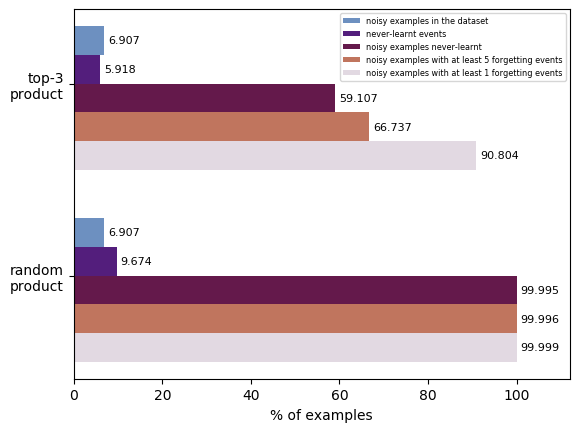

In [61]:
from matplotlib.font_manager import FontProperties
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fontP = FontProperties()
fontP.set_size('xx-small')
col = [ cm.twilight(x) for x in np.linspace(0, 1.0, 5+1) ]

plt.rcdefaults()
fig, ax = plt.subplots()
height=0.15

y_pos = np.arange(len(labels))
rect = ax.barh(y_pos - 3*height/2, noise_perc,height, align='center', color=col[1], label="noisy examples in the dataset")
autolabel(rect, ax)
rect =ax.barh(y_pos - height/2, perc_never_learnt_events,height, align='center', color=col[2], label="never-learnt events")
autolabel(rect, ax)
rect = ax.barh(y_pos + height/2, perc_noise_in_never_learnt_events,height, align='center', color=col[3],label="noisy examples never-learnt")
autolabel(rect, ax)
rect =ax.barh(y_pos + 3*height/2, perc_noise_down_to_5_forg_events,height, align='center', color=col[4],label="noisy examples with at least 5 forgetting events")
autolabel(rect, ax)
rect = ax.barh(y_pos + 5*height/2, perc_noise_down_to_1_forg_events,height, align='center', color=col[5],label="noisy examples with at least 1 forgetting events")
autolabel(rect, ax)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
plt.xlim((0, 112))
ax.invert_yaxis()
ax.set_xlabel('% of examples')
plt.legend(loc='upper right', fancybox=True,prop=fontP)


plt.savefig(savepath + f'/noise_comparison.pdf', bbox_inches='tight')